In [1]:
# base code from 
# 1: https://docs.opencv.org/4.x/da/d0c/tutorial_bounding_rects_circles.html
# 2: https://pyimagesearch.com/2018/07/23/simple-object-tracking-with-opencv/
# 3: https://www.geeksforgeeks.org/python/python-play-a-video-using-opencv/

In [2]:
# import the necessary packages
from scipy.spatial import distance as dist  # provides functions for computing distances
from collections import OrderedDict 
import numpy as np  # y'all already know
from __future__ import print_function
import cv2 as cv
import argparse
import random as rng
import matplotlib.pyplot as plt

In [3]:
def thresh_callback(val, frame):
    threshold = val
    maxR = 10**(-4)
    canny_output = cv.Canny(frame, threshold, threshold * 2)

    contours, _ = cv.findContours(canny_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # print(len(contours))

    contours_poly = [None]*len(contours)
    boundRect = []
    skipped = []
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])
        # print(radius[i])
        # if radius[i] <= maxR:
        boundRect.append(cv.boundingRect(contours_poly[i]))
        # else:
        #     skipped.append(c)
        # print(len(boundRect[i]))      

    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)

    for i in range(len(boundRect)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, contours_poly, i, color)
        cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
              (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
        # cv.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)

    # cv.imshow('Contours', drawing)
    # print(boundRect)
    return boundRect

In [4]:
class CentroidTracker():
	def __init__(self, maxDisappeared=100):
		self.objects = OrderedDict()
		self.nextObjectID = 0
		self.disappeared = OrderedDict()
		self.Positions = OrderedDict()
		self.maxDisappeared = maxDisappeared
	
	def update_Positions(self,frameNumber,CX,CY):
		objectIDs = list(CX.keys())
    	# objectCentroids = list(self.objects.values())
		for ID in objectIDs:
			if ID in self.Positions:
				self.Positions[ID] = np.append(self.Positions[ID],np.array([[frameNumber,CX[ID],CY[ID]]]),axis=0)
			else:
				self.Positions[ID] = np.array([[frameNumber,CX[ID],CY[ID]]])
	
	def register(self, centroid):
		# when registering an object we use the next available object
		# ID to store the centroid
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1
	
	def deregister(self, objectID):
		# to deregister an object ID we delete the object ID from
		# both of our respective dictionaries
		del self.objects[objectID]
		del self.disappeared[objectID]
	
	def update(self, rects):
		# check to see if the list of input bounding box rectangles
		# is empty
		if len(rects) == 0:
			# loop over any existing tracked objects and mark them
			# as disappeared
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1
				# if we have reached a maximum number of consecutive
				# frames where a given object has been marked as
				# missing, deregister it
				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)
			# return early as there are no centroids or tracking info
			# to update
			return self.objects

        # initialize an array of input centroids for the current frame
		inputCentroids = np.zeros((len(rects), 2), dtype='int')
        # loop over the bounding box rectangles
		CX = OrderedDict()
		CY = OrderedDict()
		for (i, (startX, startY, endX, endY)) in enumerate(rects):
            # use the bounding box coordinates to derive the centroid
			cX = int((startX + endX) / 2.0)
			cY = int((startY + endY) / 2.0)
			inputCentroids[i] = (cX, cY)

        # if we are currently not tracking any objects take the input
		# centroids and register each of them
		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				self.register(inputCentroids[i])
        # otherwise, are are currently tracking objects so we need to
		# try to match the input centroids to existing object
		# centroids
		else:
			# grab the set of object IDs and corresponding centroids
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())
			# compute the distance between each pair of object
			# centroids and input centroids, respectively -- our
			# goal will be to match an input centroid to an existing
			# object centroid
			D = dist.cdist(np.array(objectCentroids), inputCentroids)
			# in order to perform this matching we must (1) find the
			# smallest value in each row and then (2) sort the row
			# indexes based on their minimum values so that the row
			# with the smallest value is at the *front* of the index
			# list
			rows = D.min(axis=1).argsort()
			# next, we perform a similar process on the columns by
			# finding the smallest value in each column and then
			# sorting using the previously computed row index list
			cols = D.argmin(axis=1)[rows]

            # in order to determine if we need to update, register,
			# or deregister an object we need to keep track of which
			# of the rows and column indexes we have already examined
			usedRows = set()
			usedCols = set()
			# loop over the combination of the (row, column) index
			# tuples
			for (row, col) in zip(rows, cols):
				# if we have already examined either the row or
				# column value before, ignore it
				# val
				if row in usedRows or col in usedCols:
					continue
				# otherwise, grab the object ID for the current row,
				# set its new centroid, and reset the disappeared
				# counter
				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				CX[objectID] = inputCentroids[col][0]
				CY[objectID] = inputCentroids[col][1]
				self.disappeared[objectID] = 0
				# indicate that we have examined each of the row and
				# column indexes, respectively
				usedRows.add(row)
				usedCols.add(col)
			# compute both the row and column index we have NOT yet
			# examined
			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)   
            # in the event that the number of object centroids is
			# equal or greater than the number of input centroids
			# we need to check and see if some of these objects have
			# potentially disappeared
			if D.shape[0] >= D.shape[1]:
				# loop over the unused row indexes
				for row in unusedRows:
					# grab the object ID for the corresponding row
					# index and increment the disappeared counter
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1
					# check to see if the number of consecutive
					# frames the object has been marked "disappeared"
					# for warrants deregistering the object
					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)
            # otherwise, if the number of input centroids is greater
			# than the number of existing object centroids we need to
			# register each new input centroid as a trackable object
			else:
				for col in unusedCols:
					self.register(inputCentroids[col])
		# return the set of trackable objects
		return self.objects, CX, CY

In [5]:
def WaterShed(frame):

    src = frame
    if src is None:
        print('Could not open or find the image')
        exit(0)
    # Show source image
    # cv.imshow('Source Image', src)
    
    #----------------------------#
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
    # do the laplacian filtering as it is
    # well, we need to convert everything in something more deeper then CV_8U
    # because the kernel has some negative values,
    # and we can expect in general to have a Laplacian image with negative values
    # BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
    # so the possible negative number will be truncated
    imgLaplacian = cv.filter2D(src, cv.CV_32F, kernel)
    sharp = np.float32(src)
    imgResult = sharp - imgLaplacian
    
    #-----------------------------#
    # convert back to 8bits gray scale
    imgResult = np.clip(imgResult, 0, 255)
    imgResult = imgResult.astype('uint8')
    imgLaplacian = np.clip(imgLaplacian, 0, 255)
    imgLaplacian = np.uint8(imgLaplacian)
    #cv.imshow('Laplace Filtered Image', imgLaplacian)
    # cv.imshow('New Sharped Image', imgResult)
    #------------------------------------------#
    
    # cv.waitKey(0)
    # cv.destroyAllWindows()
    
    
    #get binary image
    bw = cv.cvtColor(imgResult, cv.COLOR_BGR2GRAY)
    _, bw = cv.threshold(bw, 40, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
    # cv.imshow('Binary Image', bw)
    # cv.waitKey(0)
    # cv.destroyAllWindows()
    
    dist = cv.distanceTransform(bw, cv.DIST_L2, 3)
    # Normalize the distance image for range = {0.0, 1.0}
    # so we can visualize and threshold it
    cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
    # cv.imshow('Distance Transform Image', dist)
    # cv.waitKey(0)
    # cv.destroyAllWindows()
    
    _, dist = cv.threshold(dist, 0.4, 1.0, cv.THRESH_BINARY)
    # Dilate a bit the dist image
    kernel1 = np.ones((3,3), dtype=np.uint8)
    dist = cv.dilate(dist, kernel1)
    # cv.imshow('Peaks', dist)
    # cv.waitKey(0)
    # cv.destroyAllWindows()
    
    dist_8u = dist.astype('uint8')
    # print(np.max(dist_8u))
    # Find total markers
    contours, _ = cv.findContours(dist_8u, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # Create the marker image for the watershed algorithm
    markers = np.zeros(dist.shape, dtype=np.int32)
    # Draw the foreground markers
    for i in range(len(contours)):
        cv.drawContours(markers, contours, i, (i+1), -1)
    # Draw the background marker
    cv.circle(markers, (5,5), 3, (255,255,255), -1)
    markers_8u = (markers * 10).astype('uint8')
    # cv.imshow('Markers', markers_8u)
    # cv.waitKey(0)
    # cv.destroyAllWindows()
    
    cv.watershed(imgResult, markers)
    #mark = np.zeros(markers.shape, dtype=np.uint8)
    mark = markers.astype('uint8')
    mark = cv.bitwise_not(mark)
    # uncomment this if you want to see how the mark
    # image looks like at that point
    #cv.imshow('Markers_v2', mark)
    # Generate random colors
    colors = []
    for contour in contours:
        colors.append((rng.randint(0,255), rng.randint(0,255), rng.randint(0,255)))
    # Create the result image
    dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
    # Fill labeled objects with random colors
    for i in range(markers.shape[0]):
        for j in range(markers.shape[1]):
            index = markers[i,j]
            if index > 0 and index <= len(contours):
                dst[i,j,:] = colors[index-1]
    
    return dst
    
    # Visualize the final image
#     cv.imshow('Final Result', dst)
#     cv.waitKey()
#     cv.destroyAllWindows()

In [6]:
def init_video(filename, thresh):
    
    #set up constants and empty lists
    numGuys = []
    perimeters = []
    t=0
    a=3;
    
    #initialize centroid tracker
    cTracker = CentroidTracker()

    # Create a VideoCapture object and read from input file

    cap = cv.VideoCapture(filename)
    
    # Check if camera opened successfully
    if (cap.isOpened()== False):
        print("Error opening video file")

    # kernel1 = cv.getStructuringElement(cv.MORPH_RECT,(a,a))
    # kernel2 = cv.getStructuringElement(cv.MORPH_CROSS,(a,a))
    kernel3 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(a,a))
    
    while(cap.isOpened()):
        t+=1
        
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            # this block zeros all non-pink pixels
            hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
            sensitivity = 150
            lower_white = np.array([150, 85, 255-sensitivity])
            upper_white = np.array([200, 255, 255])
            mask = cv.inRange(hsv, lower_white, upper_white)
            inv_mask = cv.bitwise_not(mask)
            frame = cv.bitwise_and(frame, frame, mask = mask)
            
            # turns all non-black pixels white
            black_color = np.array([0, 0, 0])
            non_black_mask = np.any(frame != black_color, axis=-1)
            frame[non_black_mask] = [255, 255, 255]
            
            #dilates the white pixels (kernel,a, & number of iterations should be played with)
            frame = cv.dilate(frame, kernel3,iterations = 1)
            
            #gets ALL rectangles
            rects = thresh_callback(thresh, mask)
            rectsToUse = []
            color = (255,0,0)
            for contour in rects:
                p = 2*contour[2]+2*contour[3]
                perimeters.append(p)
                
                #thresholds the perimeters to not include tiny boxes
                if p > 50:
                    rectsToUse.append(contour)
                    
                    #draws the rectangles
                    cv.rectangle(frame, (int(contour[0]), int(contour[1])), \
                      (int(contour[0]+contour[2]), int(contour[1]+contour[3])), color, 2)
            
            #sets up the waitkey
            # Press Q on keyboard to exit

            if cv.waitKey(25) & 0xFF == ord('q'):
                break
                
            #if there are no rectangles above threshold perimeter move on
            if not rectsToUse:
                continue
            
            cv.imshow('frame', frame)
            
            #update the tracker
            objects,CX,CY = cTracker.update(rectsToUse)
            numGuys.append(len(objects))
            
            #keep track of positions
            cTracker.update_Positions(t,CX,CY)
            

    # Break the loop
        else:
            break
    
    # When everything done, release
    # the video capture object
    cap.release()
    cv.destroyAllWindows()
    
    #histograms the perimeters
    plt.hist(perimeters,bins=50)
    plt.show() 
    
    #histograms the number of rectangles we're counting
    plt.hist(numGuys,bins=20)
    plt.show()
    
    #cTracker.Positions contains a dictionary n->arr
    #n is an integer keeping track of which object we're looking at
    #arr is a 2D array K rows, 3 columns; each row is OTF [time, x ,y]
    #K is the amount of time for which the object is tracked
    
    
    return numGuys,cTracker.Positions

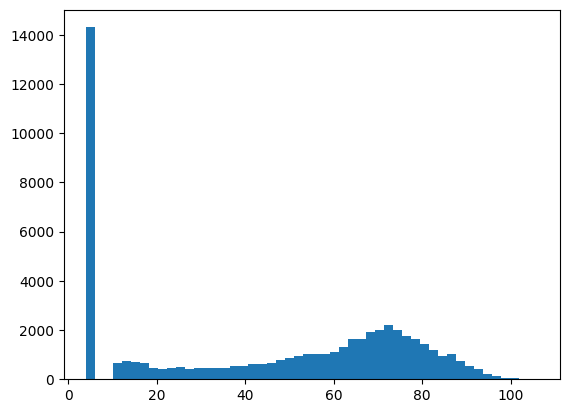

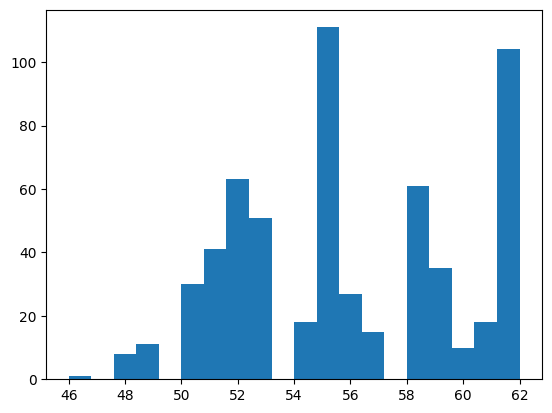

OrderedDict([(0, array([[  2, 606, 445],
       [  3, 606, 445],
       [  4, 606, 445],
       ...,
       [559, 552, 357],
       [563, 552, 356],
       [603, 550, 353]], shape=(504, 3))), (33, array([[  2, 565, 151],
       [  3, 563, 149],
       [  4, 564, 149],
       [  5, 564, 148],
       [  6, 564, 150],
       [  7, 564, 151],
       [  8, 564, 150],
       [  9, 564, 150],
       [ 10, 564, 150],
       [ 11, 564, 150],
       [ 12, 563, 148],
       [ 13, 563, 149],
       [ 14, 562, 149],
       [ 15, 562, 149],
       [ 16, 563, 148],
       [ 17, 562, 148],
       [ 18, 562, 148],
       [ 19, 562, 148],
       [ 20, 562, 147],
       [ 21, 563, 147],
       [ 22, 562, 145],
       [ 23, 563, 146],
       [ 24, 562, 145],
       [ 25, 562, 145],
       [ 26, 563, 145],
       [ 27, 562, 144],
       [ 28, 561, 143],
       [ 29, 563, 143],
       [ 30, 563, 143],
       [ 31, 563, 144],
       [ 32, 563, 143],
       [ 33, 562, 143],
       [ 34, 563, 142],
       [ 35

In [7]:
numGuys,pos = init_video("DroneVidsLamontFarm/Aug7_11_57-003_still_ish.MP4", 200)

